Topic Analysis using LDA

In [24]:
#Libraries 
import pandas as pd
import snscrape.modules.twitter as sntwitter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
from gensim.utils import simple_preprocess
import gensim.downloader as api
import gensim.corpora as corpora

import nltk
#run once and comment it out to avoid it downloading multiple times
nltk.download('stopwords') 
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

import string
import re
import textblob
from textblob import TextBlob

from wordcloud import WordCloud, STOPWORDS
from wordcloud import ImageColorGenerator
from PIL import Image
from emot.emo_unicode import UNICODE_EMOJI

porter = PorterStemmer()
lemmatizer = WordNetLemmatizer() 

import pyLDAvis.gensim_models 
import pickle 
import pyLDAvis
import os

import warnings
from pprint import pprint
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pdhiman\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pdhiman\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pdhiman\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\pdhiman\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [5]:
#Data Load and verification
tweetdata = pd.read_csv('data/tweets_all.csv')
tweetdata.head()

,Unnamed: 0,Date,source,location,tweet,num_of_likes,num_of_retweet
0,0,2022-11-01 23:59:59+00:00,Twitter for iPhone,NaN,@GHOSTofSURF @ThatEricAlper Always on spot! 🤪,0,0
1,1,2022-11-01 23:59:59+00:00,Twitter Web App,"Connecticut, USA",@GreenwaldEd @MadeInTheUSANJ @RepMTG If #GOP g...,2,1
2,2,2022-11-01 23:59:59+00:00,Twitter for Android,BBB 🫧,Let's vote! We have a chance to give them more...,0,0
3,3,2022-11-01 23:59:59+00:00,Twitter for iPhone,Red State USA,This is @KathyHochul NY. Get out and vote for ...,0,0
4,4,2022-11-01 23:59:59+00:00,Twitter for Android,"Minnesota, USA",@tophat595 @KihneSheila Thanks democrats! You ...,1,0


Data Preproccessing 
- Clean Null Values
- Stopwords
- Punctuation Removal
- Removing Emojis
- Removing URLs and Usernames
- Removing Hashtags
- Lemmatization
- Remove Special characters (amp)

In [9]:
# Cleaning Location Null / Nan Values
tweetdata['location'] = tweetdata['location'].fillna('Unknown')
tweetdata.head(5)

,Unnamed: 0,Date,source,location,tweet,num_of_likes,num_of_retweet,tweet_text_processed
0,0,2022-11-01 23:59:59+00:00,Twitter for iPhone,Unknown,@GHOSTofSURF @ThatEricAlper Always on spot! 🤪,0,0,always spot
1,1,2022-11-01 23:59:59+00:00,Twitter Web App,"Connecticut, USA",@GreenwaldEd @MadeInTheUSANJ @RepMTG If #GOP g...,2,1,get majority dont mtg cld head house cmte marc...
2,2,2022-11-01 23:59:59+00:00,Twitter for Android,BBB 🫧,Let's vote! We have a chance to give them more...,0,0,let vote chance give exposure social medium do...
3,3,2022-11-01 23:59:59+00:00,Twitter for iPhone,Red State USA,This is @KathyHochul NY. Get out and vote for ...,0,0,ny get vote
4,4,2022-11-01 23:59:59+00:00,Twitter for Android,"Minnesota, USA",@tophat595 @KihneSheila Thanks democrats! You ...,1,0,thanks democrat ruin everything


In [7]:
## Cleaning Tweets data
eng_stop_words = list(stopwords.words('english'))
emoji = list(UNICODE_EMOJI.keys())

def preprocess_tweets(tweet):
    tweet = tweet.lower()  #lowercase
    tweet = re.sub('@[^\s]+','',tweet)  # Removing Usernames
    tweet = re.sub('http[^\s]+','',tweet) # Removing URLs.
    tweet = re.sub(r"www.\S+", "", tweet)
    tweet = re.sub("@[A-Za-z0-9_]+","", tweet) # Removing mentions
    tweet = re.sub("#[A-Za-z0-9_]+","", tweet) # Removing Hashtags
    tweet = re.sub(r"amp", "", tweet)

    punct = str.maketrans('', '', string.punctuation+string.digits) # Removing Punctuations
    tweet = tweet.translate(punct)

    # tokenizing words and removing stop words from the tweet text
    tokens = word_tokenize(tweet)  
    filtered_words = [w for w in tokens if w not in eng_stop_words]
    filtered_words = [w for w in filtered_words if w not in emoji]
    # lemmetizing words
    lemmatizer = WordNetLemmatizer() 
    lemma_words = [lemmatizer.lemmatize(w) for w in filtered_words]
    tweet = " ".join(lemma_words)

    return tweet


In [10]:
tweetdata['tweet_text_processed'] = tweetdata['tweet'].apply(preprocess_tweets)
tweetdata.head(5)

,Unnamed: 0,Date,source,location,tweet,num_of_likes,num_of_retweet,tweet_text_processed
0,0,2022-11-01 23:59:59+00:00,Twitter for iPhone,Unknown,@GHOSTofSURF @ThatEricAlper Always on spot! 🤪,0,0,always spot
1,1,2022-11-01 23:59:59+00:00,Twitter Web App,"Connecticut, USA",@GreenwaldEd @MadeInTheUSANJ @RepMTG If #GOP g...,2,1,get majority dont mtg cld head house cmte marc...
2,2,2022-11-01 23:59:59+00:00,Twitter for Android,BBB 🫧,Let's vote! We have a chance to give them more...,0,0,let vote chance give exposure social medium do...
3,3,2022-11-01 23:59:59+00:00,Twitter for iPhone,Red State USA,This is @KathyHochul NY. Get out and vote for ...,0,0,ny get vote
4,4,2022-11-01 23:59:59+00:00,Twitter for Android,"Minnesota, USA",@tophat595 @KihneSheila Thanks democrats! You ...,1,0,thanks democrat ruin everything


Exploratory analysis 
- Generating Wordcloud to review most used words

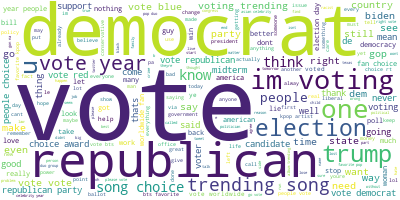

In [11]:
tweet_string = ','.join(list(tweetdata['tweet_text_processed'].values))  ## Joining processed tweets to form a string
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')  # Wordcloud Object
wordcloud.generate(tweet_string)  ## Generating wordcloud
wordcloud.to_image()

Preparing for LDA Analysis


In [19]:
# Converting document (in our case tweets)  to array for doc2bow to process and create bag of word Corpus. 

def sent2words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
data = tweetdata.tweet_text_processed.values.tolist()
data_words = list(sent2words(data))

In [21]:
id2word = corpora.Dictionary(data_words) # Create Dictionary
texts = data_words  # Create Corpus
corpus = [id2word.doc2bow(text) for text in texts] # Term Document Frequency

print(corpus[:1][0][:30])

[(0, 1), (1, 1)]


In [22]:
print(id2word)

Dictionary(63806 unique tokens: ['always', 'spot', 'army', 'cld', 'cmte']...)


Building a LDA Model

In [25]:
num_topics = 10  # number of topics
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.075*"vote" + 0.018*"democrat" + 0.016*"people" + 0.012*"get" + '
  '0.010*"republican" + 0.008*"year" + 0.008*"election" + 0.007*"one" + '
  '0.007*"choice" + 0.006*"party"'),
 (1,
  '0.050*"vote" + 0.014*"de" + 0.012*"que" + 0.009*"republican" + 0.008*"la" + '
  '0.007*"le" + 0.006*"people" + 0.006*"year" + 0.006*"love" + '
  '0.006*"election"'),
 (2,
  '0.082*"vote" + 0.028*"year" + 0.021*"people" + 0.017*"blue" + '
  '0.015*"choice" + 0.014*"republican" + 0.011*"award" + 0.009*"voting" + '
  '0.008*"tomorrow" + 0.007*"know"'),
 (3,
  '0.098*"vote" + 0.015*"election" + 0.010*"democrat" + 0.009*"want" + '
  '0.009*"red" + 0.009*"republican" + 0.008*"right" + 0.007*"tomorrow" + '
  '0.006*"people" + 0.006*"country"'),
 (4,
  '0.041*"vote" + 0.034*"voting" + 0.030*"im" + 0.026*"choice" + '
  '0.019*"trending" + 0.019*"song" + 0.014*"people" + 0.010*"year" + '
  '0.010*"republican" + 0.009*"democrat"'),
 (5,
  '0.048*"democrat" + 0.017*"vote" + 0.017*"election" + 0.013*"republi

Assigning each tweet with an identified topic

In [27]:
topic_dict = {'dominant_topic':[], 'perc_contribution':[], 'topic_keywords':[]}

for i, row in enumerate(lda_model[corpus]):
    
    row = sorted(row, key=lambda x: x[1], reverse=True)
    for j, (topic_num, prop_topic) in enumerate(row):
        wp = lda_model.show_topic(topic_num)
        topic_keywords = ", ".join([word for word, prop in wp])
        topic_dict['dominant_topic'].append(int(topic_num))
        topic_dict['perc_contribution'].append(round(prop_topic, 3))
        topic_dict['topic_keywords'].append(topic_keywords)
        break

df_topics = pd.DataFrame(topic_dict)
contents = pd.Series(texts)

#df_topics['post'] = df['post']
df_topics.head()

,dominant_topic,perc_contribution,topic_keywords
0,0,0.700,"vote, democrat, people, get, republican, year,..."
1,1,0.964,"vote, de, que, republican, la, le, people, yea..."
2,5,0.953,"democrat, vote, election, republican, trump, p..."
3,0,0.775,"vote, democrat, people, get, republican, year,..."
4,5,0.820,"democrat, vote, election, republican, trump, p..."


Analysis LDA Model Results with pyLDAvis
- Top 10 Topics


In [26]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(num_topics))
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

c:\Users\pdhiman\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.048031  0.015807       1        1  15.444405
6      0.063493 -0.002653       2        1  15.377898
5      0.061427 -0.056154       3        1  13.116870
8      0.050394 -0.072355       4        1  11.176442
3      0.021247  0.014587       5        1   9.980661
0     -0.012996  0.010409       6        1   9.864020
4     -0.005452  0.078753       7        1   7.924850
1     -0.144103 -0.092221       8        1   6.263044
7     -0.005228  0.020193       9        1   5.566391
2     -0.076813  0.083633      10        1   5.285420, topic_info=         Term          Freq         Total Category  logprob  loglift
39       vote  53339.000000  53339.000000  Default  30.0000  30.0000
210    voting  14100.000000  14100.000000  Default  29.0000  29.0000
160      year   6451.000000   6451.000000  Default  28.0000  28.0000
158    choice   5046.000000   5046.000000  Default  27.0000  27.0000
904        im   5112.000000   5112.000000  Default  26.0000  26.0000
..        ...           ...           ...      ...      ...      ...
674  election    260.396337  17330.938488  Topic10  -5.4681  -1.2578
139       way    166.703614   2686.209659  Topic10  -5.9141   0.1605
183      want    183.605583   4953.042217  Topic10  -5.8176  -0.3547
28      every    164.338380   2757.538793  Topic10  -5.9284   0.1201
300      time    158.203614   3864.957478  Topic10  -5.9665  -0.2556

[904 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
21316      8  0.980039       aaa
11915     10  0.912667     aaron
1171       1  0.717090    abbott
1171       2  0.016297    abbott
1171       3  0.052967    abbott
...      ...       ...       ...
3142       5  0.922377       zee
21265      1  0.936210  zelensky
19492      2  0.941645     ありかとう
2649       5  0.988509    방탄소년단진
26396      1  0.948828        진짜

[3143 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 7, 6, 9, 4, 1, 5, 2, 8, 3])

,dominant_topic,perc_contribution,topic_keywords
0,2,0.700,"vote, democrat, republican, voting, new, one, ..."
1,3,0.964,"vote, want, democrat, dont, people, republican..."
2,3,0.748,"vote, want, democrat, dont, people, republican..."
3,3,0.775,"vote, want, democrat, dont, people, republican..."
4,9,0.820,"vote, democrat, republican, election, trump, p..."
